In [1]:
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, auc, roc_curve, f1_score
from sklearn.decomposition import PCA
from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

models = []
models.append(('LR', LogisticRegression(max_iter=1000)))
models.append(('KNN9', KNeighborsClassifier(n_neighbors=9)))
models.append(('KNN7', KNeighborsClassifier(n_neighbors=7)))
models.append(('KNN5', KNeighborsClassifier()))
models.append(('KNN3', KNeighborsClassifier(n_neighbors=3)))
models.append(('KNN1', KNeighborsClassifier(n_neighbors=1)))
models.append(('RF', RandomForestClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('MLP', MLPClassifier()))

names = []
trained_models = []


def buildDataset(resample="", drop=['Name', 'Malware']):
    benign = pd.read_csv("./dataset_benign.csv")
    malware = pd.read_csv("./dataset_malware.csv")

    data = pd.concat([benign, malware], ignore_index=True)

    X = data.drop(drop, axis=1)
    y = data['Malware']

    names = X.columns
    # print(names)

    if (resample == "-o"):
        print("Aplicando oversampling...")
        smote = SMOTE(random_state=42)
        X, y = smote.fit_resample(X, y)
    elif (resample == "-u"):
        print("\n\n\nAplicando undersampling...")
        nearmiss = NearMiss(version=1)
        X, y = nearmiss.fit_resample(X, y)

    print("Número de muestras totales:", len(X), "\n\n\n")
    return X, y


def trainTest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=101)

    sc = StandardScaler().fit(X_train)

    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)

    # skpca = PCA(n_components=2)

    # X_train = skpca.fit_transform(X_train)
    # X_test = skpca.transform(X_test)

    print(f'Número de características usadas: {X_train.shape[1]} \n\n\n')

    return X_train, X_test, y_train, y_test


def crossValidationScore(X_train, y_train):
    # evaluate each model in turn
    results = []
    names = []
    scoring = 'accuracy'
    print("COMPARACIÓNN DE ALGORITMOS MEDIANTE CROSS-VALIDATION")
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10)
        trained_model = model.fit(X_train, y_train)
        cv_results = model_selection.cross_val_score(
            trained_model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        trained_models.append((name, trained_model))

    print("\n\n\n")


def compareMLAs(X_train, X_test, y_train, y_test):
    MLA_columns = []
    MLA_compare = pd.DataFrame(columns=MLA_columns)

    row_index = 0
    for name, model in trained_models:

        predicted = model.predict(X_test)

        fp, tp, th = roc_curve(y_test, predicted)
        MLA_name = name
        MLA_compare.loc[row_index, 'MLA used'] = MLA_name
        MLA_compare.loc[row_index, 'Train Accuracy'] = round(
            model.score(X_train, y_train), 4)
        MLA_compare.loc[row_index, 'Test Accuracy'] = round(
            model.score(X_test, y_test), 4)
        MLA_compare.loc[row_index, 'Precision'] = precision_score(
            y_test, predicted)
        MLA_compare.loc[row_index, 'Recall'] = recall_score(y_test, predicted)
        MLA_compare.loc[row_index, 'F1-Score'] = f1_score(
            y_test, predicted)
        # MLA_compare.loc[row_index, 'AUC'] = auc(fp, tp)

        row_index += 1

    MLA_compare.sort_values(by=['Test Accuracy'],
                            ascending=False, inplace=True)
    print(MLA_compare)

In [11]:
resample="-u" #"-u" -> aplicar undersampling    "-o" -> aplicar oversampling    "" -> no aplica ningun resampling

X,y = buildDataset(resample)
print(X)
X_train, X_test, y_train, y_test = trainTest(X, y)
# sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
# X_train = sel.fit_transform(X_train)
# X_test = sel.transform(X_test)

crossValidationScore(X_train, y_train)
compareMLAs(X_train, X_test, y_train, y_test)




Aplicando undersampling...
Número de muestras totales: 8228 



      e_magic  e_cblp  e_cp  e_crlc  e_cparhdr  e_minalloc  e_maxalloc  e_ss  \
0       23117     144     3       0          4           0       65535     0   
1       23117     144     3       0          4           0       65535     0   
2       23117     144     3       0          4           0       65535     0   
3       23117     144     3       0          4           0       65535     0   
4       23117     144     3       0          4           0       65535     0   
...       ...     ...   ...     ...        ...         ...         ...   ...   
8223    23117     144     3       0          4           0       65535     0   
8224    23117     144     3       0          4           0       65535     0   
8225    23117     144     3       0          4           0       65535     0   
8226    23117     144     3       0          4           0       65535     0   
8227    23117      80     2       0          4       

c:\Users\samue\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
c:\Users\samue\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLP: 0.997874 (0.003539)






In [ ]:
pd.options.display.float_format = '{:.10f}'.format
df = pd.DataFrame(
    zip(X.columns, abs(trained_models[6][-1].feature_importances_)),
    columns=["feature", "importance"],
).sort_values("importance", ascending=False).reset_index(drop=True)

# pd.set_option('display.max_rows', df.shape[0]+1)
df

# sns.barplot(x = 'Características', y = 'Importancia', data = df)

# print(df)

                              e_magic    e_cblp      e_cp    e_crlc  \
e_magic                           NaN       NaN       NaN       NaN   
e_cblp                            NaN  1.000000  0.585965  0.591523   
e_cp                              NaN  0.585965  1.000000  0.223731   
e_crlc                            NaN  0.591523  0.223731  1.000000   
e_cparhdr                         NaN  0.265601  0.083290  0.452975   
...                               ...       ...       ...       ...   
ImageDirectoryEntryExport         NaN -0.010140 -0.009502 -0.002945   
ImageDirectoryEntryImport         NaN -0.007437 -0.006979 -0.000727   
ImageDirectoryEntryResource       NaN -0.008362 -0.007757 -0.001719   
ImageDirectoryEntryException      NaN -0.010161 -0.009602 -0.002977   
ImageDirectoryEntrySecurity       NaN -0.002818 -0.002673 -0.000898   

                              e_cparhdr  e_minalloc  e_maxalloc      e_ss  \
e_magic                             NaN         NaN         NaN       

<AxesSubplot:>

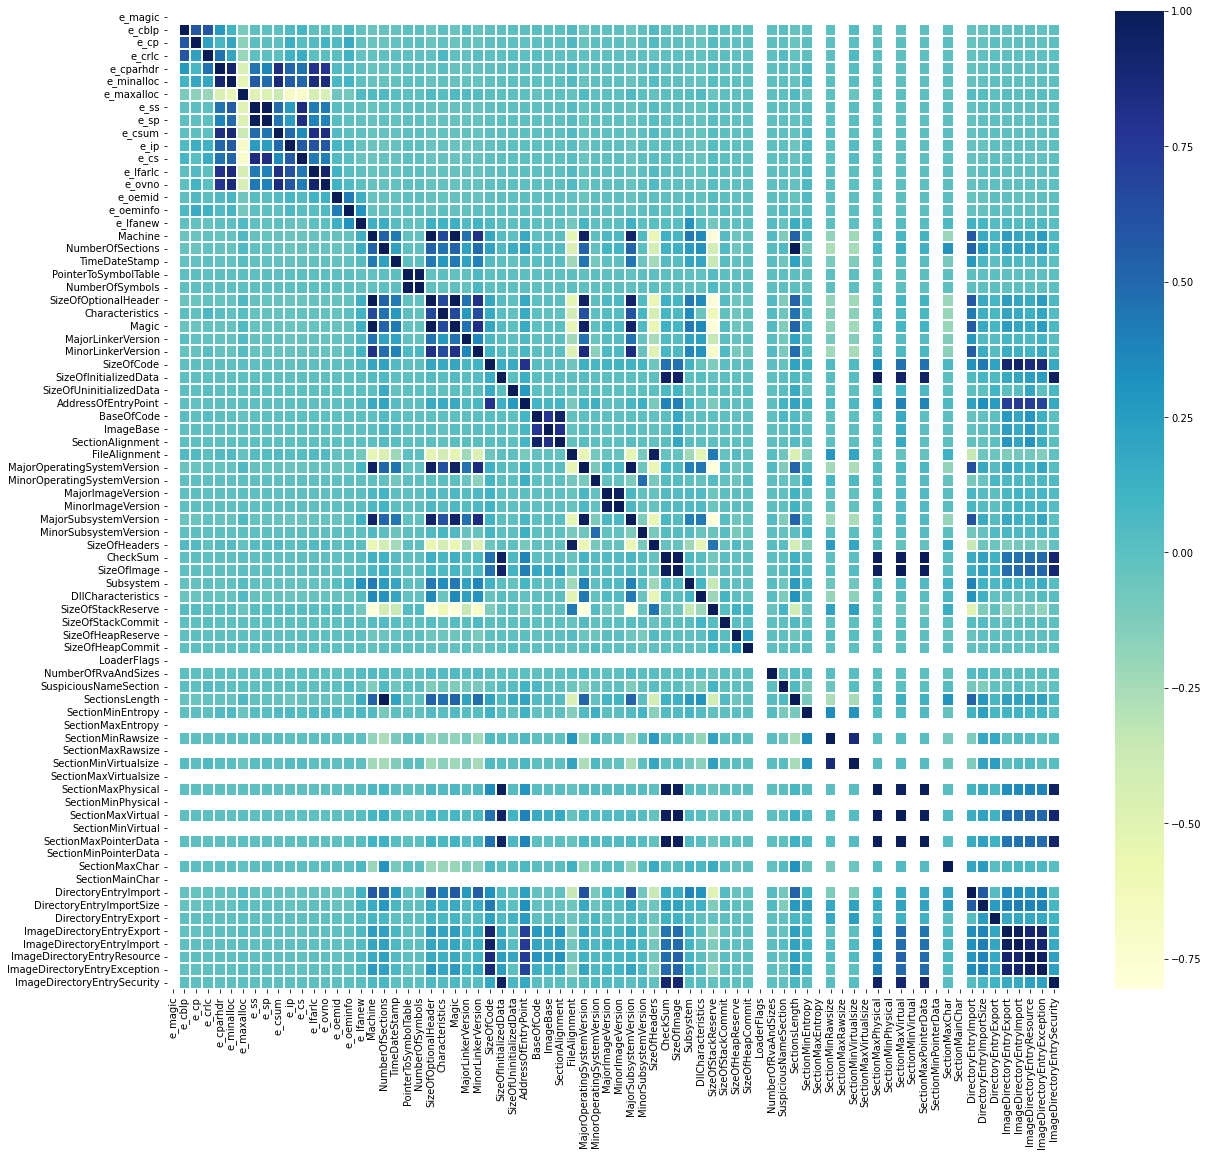

In [10]:
corrMatrix = X.corr()
print(corrMatrix)
f, ax = plt.subplots(figsize =(20, 18))
sns.heatmap(corrMatrix, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

In [6]:
upper_tri = corrMatrix.where(np.triu(np.ones(corrMatrix.shape),k=1).astype(bool))
# print(upper_tri)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.75)]
print(to_drop)

['e_minalloc', 'e_sp', 'e_csum', 'e_cs', 'e_lfarlc', 'e_ovno', 'NumberOfSymbols', 'SizeOfOptionalHeader', 'Magic', 'MinorLinkerVersion', 'AddressOfEntryPoint', 'ImageBase', 'SectionAlignment', 'MajorOperatingSystemVersion', 'MinorImageVersion', 'MajorSubsystemVersion', 'SizeOfHeaders', 'CheckSum', 'SizeOfImage', 'SectionsLength', 'SectionMinVirtualsize', 'SectionMaxPhysical', 'SectionMaxVirtual', 'SectionMaxPointerData', 'ImageDirectoryEntryExport', 'ImageDirectoryEntryImport', 'ImageDirectoryEntryResource', 'ImageDirectoryEntryException', 'ImageDirectoryEntrySecurity']


In [7]:
# to_drop.append('Name')

to_drop = ['Name', 'Malware', 'e_minalloc', 'e_sp', 'e_csum', 'e_cs', 'e_lfarlc', 'e_ovno', 'NumberOfSymbols', 'SizeOfOptionalHeader', 'Magic', 'MinorLinkerVersion', 'AddressOfEntryPoint', 'ImageBase', 'SectionAlignment', 'MajorOperatingSystemVersion', 'MinorImageVersion', 'MajorSubsystemVersion', 'SizeOfHeaders', 'CheckSum', 'SizeOfImage', 'SectionsLength', 'SectionMinVirtualsize', 'SectionMaxPhysical', 'SectionMaxVirtual', 'SectionMaxPointerData', 'ImageDirectoryEntryExport', 'ImageDirectoryEntryImport', 'ImageDirectoryEntryResource', 'ImageDirectoryEntryException', 'ImageDirectoryEntrySecurity']

resample="-u" #"-u" -> aplicar undersampling    "-o" -> aplicar oversampling    "" -> no aplica ningun resampling

X,y = buildDataset(resample, to_drop)
X_train, X_test, y_train, y_test = trainTest(X, y)
# sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
# X_train = sel.fit_transform(X_train)
# X_test = sel.transform(X_test)

crossValidationScore(X_train, y_train)
compareMLAs(X_train, X_test, y_train, y_test)




Aplicando undersampling...
Número de muestras totales: 8228 



Número de características usadas: 47 



COMPARACIÓNN DE ALGORITMOS MEDIANTE CROSS-VALIDATION
LR: 0.998480 (0.001798)
KNN9: 0.996506 (0.001804)
KNN7: 0.996961 (0.001798)
KNN5: 0.996961 (0.001798)
KNN3: 0.997417 (0.001805)
KNN1: 0.998480 (0.001359)
RF: 0.999240 (0.001830)
CART: 0.998785 (0.001771)
NB: 0.927988 (0.062129)
SVM: 0.997265 (0.002015)
MLP: 0.998177 (0.001772)




   MLA used  Train Accuracy  Test Accuracy  Precision    Recall  F1-Score
18     CART          1.0000         1.0000   1.000000  1.000000  1.000000
17       RF          1.0000         1.0000   1.000000  1.000000  1.000000
6        RF          1.0000         1.0000   1.000000  1.000000  1.000000
7      CART          1.0000         1.0000   1.000000  1.000000  1.000000
0        LR          0.9994         0.9982   0.996411  1.000000  0.998203
10      MLP          0.9995         0.9982   0.996411  1.000000  0.998203
16     KNN1          1.0000         0.9